Zur Berechnung der Scleifen wird zusätzlich das OpenCV Modul benötigt.

pip install opencv-python


In [1]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')


2024-03-20 20:11:47.752866: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-03-20 20:11:49.509292: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-03-20 20:11:49.532892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-20 20:11:49.533074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA GeForce RTX 4060 Ti computeCapability: 8.9
coreClock: 2.595GHz coreCount: 34 deviceMemorySize: 15.70GiB deviceMemoryBandwidth: 268.25GiB/s
2024-03-20 20:11:49.533104: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-03-20 20:11:49.591683: I tensorflow/stream_execut

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

cutor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2024-03-20 20:11:49.601426: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcurand.so.10
2024-03-20 20:11:49.603832: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcusolver.so.11
2024-03-20 20:11:49.607070: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcusparse.so.11
2024-03-20 20:11:49.607725: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-03-20 20:11:49.607852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-20 20:11:49.608049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

In [2]:
from tensorflow.keras.datasets import mnist
import json

def load_mnist_data():
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    return train_images, train_labels, test_images, test_labels

def save_best_parameters(test_loss, test_accuracy, parameters, file_path='best_parameters.json'):
    try:
        # Versuchen, die bisher besten Parameter zu laden
        with open(file_path, 'r') as file:
            best_parameters = json.load(file)
            best_test_loss = best_parameters.get('test_loss', float('inf'))
            best_test_accuracy = best_parameters.get('test_accuracy', 0)
    except FileNotFoundError:
        best_test_loss = float('inf')
        best_test_accuracy = 0

    # Überprüfen, ob die aktuellen Metriken besser sind
    if test_loss < best_test_loss or test_accuracy > best_test_accuracy:
        # Aktuelle Parameter und Metriken als die neuen besten speichern
        best_parameters = {
            'test_loss': test_loss,
            'test_accuracy': test_accuracy,
            'parameters': parameters
        }
        with open(file_path, 'w') as file:
            json.dump(best_parameters, file, indent=4)
        print("Neue beste Parameter und Metriken gespeichert.")
        return True
    else:
        print("Die aktuellen Metriken sind nicht besser als die bisher besten.")
        return False

def load_best_parameters(file_path='best_parameters.json'):
    try:
        with open(file_path, 'r') as file:
            best_parameters = json.load(file)
            return best_parameters['parameters']
    except FileNotFoundError:
        return None  # oder setzen Sie Standardwerte

In [3]:
# data_preprocess.py
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

def preprocess_data(train_images, train_labels, test_images, test_labels, test_size=0.1, random_seed=2):
    if K.image_data_format() == 'channels_first':
        train_images = train_images.reshape(train_images.shape[0], 1, 28, 28)
        test_images = test_images.reshape(test_images.shape[0], 1, 28, 28)
        input_shape = (1, 28, 28)
    else:
        train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
        test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
        input_shape = (28, 28, 1)
    
    train_images = train_images.astype('float32') / 255
    test_images = test_images.astype('float32') / 255

    train_labels = tf.keras.utils.to_categorical(train_labels, 10)
    test_labels = tf.keras.utils.to_categorical(test_labels, 10)

    X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size=test_size, random_state=random_seed)

    return X_train, X_val, Y_train, Y_val, test_images, test_labels, input_shape


In [4]:
# model_training.py
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

def train_model(X_train, Y_train, X_val, Y_val, input_shape, epochs=30, batch_size=128, early_stopping_enabled=True):  # `epochs` als Parameter hinzufügen
    model = Sequential([

        Conv2D(32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=input_shape),
        Conv2D(32, kernel_size=(5,5), padding='Same', activation='relu'),
        MaxPool2D(pool_size=(2,2)),

        Dropout(0.5),

        Conv2D(64, kernel_size=(3,3), padding='Same', activation='gelu'),
        Conv2D(64, kernel_size=(3,3), padding='Same', activation='gelu'),
        MaxPool2D(pool_size=(2,2), strides=(2,2)),

        Dropout(0.25),
        
        Flatten(),

        Dense(128, activation="relu"),
        Dropout(0.5),

        Dense(10, activation="softmax")

    ])

    optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=False,
        vertical_flip=False
    )

    datagen.fit(X_train)


    
    train_steps = X_train.shape[0] // batch_size
    valid_steps = X_val.shape[0] // batch_size

    callbacks = [ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.000001,
    )]

    early_stopping_callback = None
    if early_stopping_enabled:
        early_stopping_callback = EarlyStopping(
            monitor="val_accuracy",
            patience=10,
            verbose=1,
            mode="max",
            restore_best_weights=True,
        )
        callbacks.append(early_stopping_callback)

    history = model.fit(
        datagen.flow(X_train, Y_train, batch_size=batch_size), 
        epochs=epochs, 
        validation_data=(X_val, Y_val),
        validation_steps=valid_steps,
        verbose=2,
        steps_per_epoch=train_steps,
        callbacks=callbacks
    )

    return model, history, callbacks, early_stopping_callback


Beste Parameter geladen: {'angegebene epochs': 150, 'tatsaelich benoetigte epochs': 39, 'batch_size': 128, 'Split der Testdaten:': 0.2, 'Seed': 2}


2024-03-20 20:11:51.087770: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 20:11:51.089575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-20 20:11:51.089738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA GeForce RTX 4060 Ti computeCapability: 8.9
coreClock: 2.595GHz coreCount: 34 deviceMemorySize: 15.70GiB deviceMemoryBandwidth: 268.25GiB/s
2024-03-20 20:11:51.089809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (

Epoch 1/100


2024-03-20 20:11:52.394874: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-03-20 20:11:52.432270: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8902
2024-03-20 20:11:52.491371: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-20 20:11:52.491390: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-03-20 20:11:52.491604: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-20 20:11:52.540597: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-03-20 20:11:52.541020: I tensorflow/stream_exec

375/375 - 11s - loss: 0.7281 - accuracy: 0.7659 - val_loss: 0.1259 - val_accuracy: 0.9628
Epoch 2/100
375/375 - 9s - loss: 0.2439 - accuracy: 0.9281 - val_loss: 0.0786 - val_accuracy: 0.9761
Epoch 3/100
375/375 - 9s - loss: 0.1732 - accuracy: 0.9509 - val_loss: 0.0626 - val_accuracy: 0.9823
Epoch 4/100
375/375 - 9s - loss: 0.1450 - accuracy: 0.9599 - val_loss: 0.0598 - val_accuracy: 0.9836
Epoch 5/100
375/375 - 9s - loss: 0.1282 - accuracy: 0.9642 - val_loss: 0.0436 - val_accuracy: 0.9869
Epoch 6/100
375/375 - 9s - loss: 0.1203 - accuracy: 0.9675 - val_loss: 0.0418 - val_accuracy: 0.9868
Epoch 7/100
375/375 - 9s - loss: 0.1132 - accuracy: 0.9681 - val_loss: 0.0324 - val_accuracy: 0.9891
Epoch 8/100
375/375 - 9s - loss: 0.1046 - accuracy: 0.9727 - val_loss: 0.0372 - val_accuracy: 0.9898
Epoch 9/100
375/375 - 9s - loss: 0.1000 - accuracy: 0.9729 - val_loss: 0.0331 - val_accuracy: 0.9909
Epoch 10/100
375/375 - 9s - loss: 0.0963 - accuracy: 0.9743 - val_loss: 0.0397 - val_accuracy: 0.9884


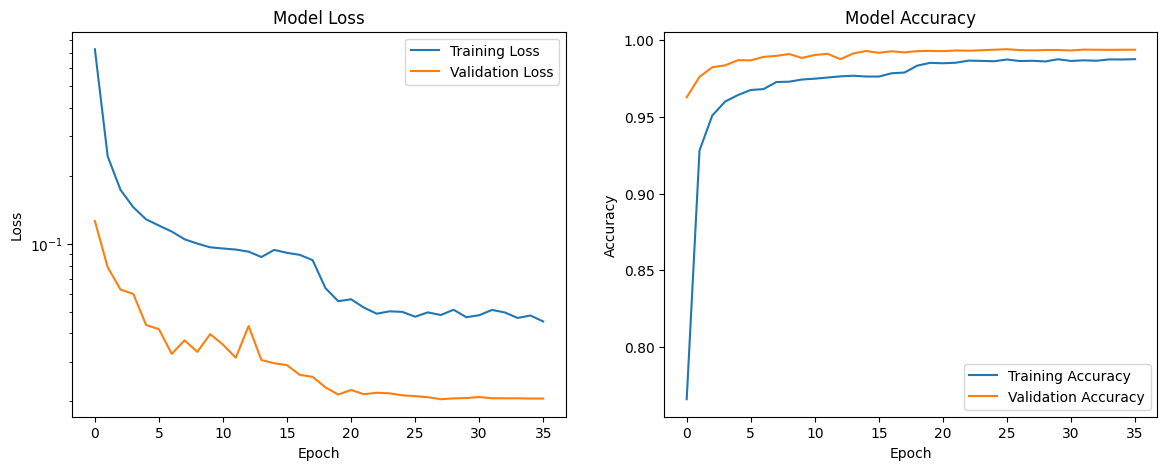

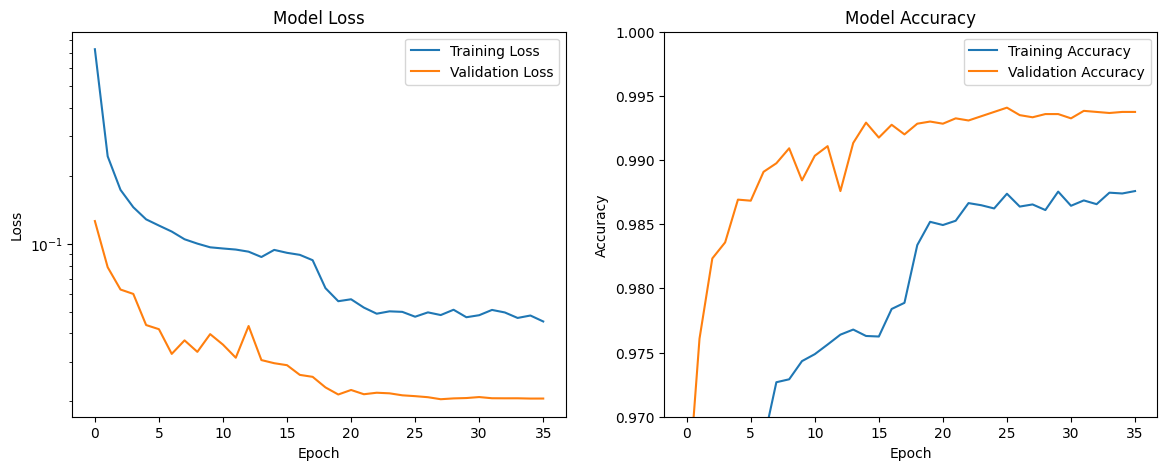

In [5]:
# main.py
from data_loader import load_mnist_data
from data_preprocess import preprocess_data
from model_training_martin import train_model
from my_plot import plot_training_history
from data_loader import load_best_parameters
from data_loader import save_best_parameters

# Global festgelegte Parameter
TEST_SIZE = 0.2 # Größe von den Validierungsdaten beim Split // Achtung: zum Testen des Modells wird IMMER der MNIST-Testdatensatz verwendet, siehe: https://ai.stackexchange.com/questions/37577/how-is-mnist-only-providing-the-training-and-the-test-sets-what-about-the-valid
epochs = 100 # Anzahl der Epochen // bricht aber sowieso nach der "idealen" Anzahl ab wenn early_stopping_enabled 1 ist
batch_size = 128
SEED = 2
early_stopping_enabled = True

def main():
    # Daten laden
    train_images, train_labels, test_images, test_labels = load_mnist_data()
    
    # Daten vorverarbeiten, mit dem global festgelegten Test Size
    X_train, X_val, Y_train, Y_val, test, Y_test, input_shape = preprocess_data(train_images, train_labels, test_images, test_labels, test_size=TEST_SIZE, random_seed=SEED)
    
    best_parameters = load_best_parameters()
    if best_parameters:
        # Verwende die besten Parameter für Training
        print("Beste Parameter geladen:", best_parameters)
    else:
        print("Keine gespeicherten besten Parameter gefunden. Verwenden der Standardwerte.")

    # Modell trainieren, mit der global festgelegten Anzahl von Epochen
    model, history, callbacks, early_stopping_callback = train_model(X_train, Y_train, X_val, Y_val, input_shape, epochs=epochs, batch_size=batch_size, early_stopping_enabled=early_stopping_enabled)
    
    model.summary()
    # Modell evaluieren
    score = model.evaluate(test, Y_test, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')
    
    # Speichern der Parameter für VErgleich bei zukünftigen Training
    if early_stopping_callback:
        tatsaechlich_benoetigte_epochs = early_stopping_callback.stopped_epoch + 1
    else:
        tatsaechlich_benoetigte_epochs = epochs
    test_loss = score[0]
    test_accuracy = score[1]
    parameters = {
        'angegebene epochs': epochs,
        'tatsaelich benoetigte epochs': tatsaechlich_benoetigte_epochs,
        'batch_size': batch_size,
        'Split der Testdaten:': TEST_SIZE,
        'Seed' : SEED,
    }

    is_better = save_best_parameters(test_loss, test_accuracy, parameters)
    
    if is_better:
        json_string = model.to_json()
        open('model_architecture.json','w').write(json_string)
        # Save the weights
        model.save_weights('model_weights.h5',overwrite=True)

    # Trainingsverlauf plotten
    plot_training_history(history)
    plot_training_history(history, accuracy_ylim_bottom=0.97, accuracy_ylim_top=1.0)

if __name__ == '__main__':
    main()

Epoch 1/100
375/375 - 9s - loss: 0.7180 - accuracy: 0.7679 - val_loss: 0.1031 - val_accuracy: 0.9688
Epoch 2/100
375/375 - 9s - loss: 0.2294 - accuracy: 0.9345 - val_loss: 0.0807 - val_accuracy: 0.9743
Epoch 3/100
375/375 - 9s - loss: 0.1652 - accuracy: 0.9537 - val_loss: 0.0670 - val_accuracy: 0.9797
Epoch 4/100
375/375 - 9s - loss: 0.1367 - accuracy: 0.9616 - val_loss: 0.0545 - val_accuracy: 0.9822
Epoch 5/100
375/375 - 9s - loss: 0.1243 - accuracy: 0.9655 - val_loss: 0.0442 - val_accuracy: 0.9863
Epoch 6/100
375/375 - 9s - loss: 0.1126 - accuracy: 0.9697 - val_loss: 0.0320 - val_accuracy: 0.9894
Epoch 7/100
375/375 - 9s - loss: 0.1094 - accuracy: 0.9710 - val_loss: 0.0436 - val_accuracy: 0.9888
Epoch 8/100
375/375 - 8s - loss: 0.1009 - accuracy: 0.9730 - val_loss: 0.0401 - val_accuracy: 0.9893
Epoch 9/100
375/375 - 9s - loss: 0.0996 - accuracy: 0.9732 - val_loss: 0.0331 - val_accuracy: 0.9902
Epoch 10/100
375/375 - 9s - loss: 0.0939 - accuracy: 0.9752 - val_loss: 0.0375 - val_accura

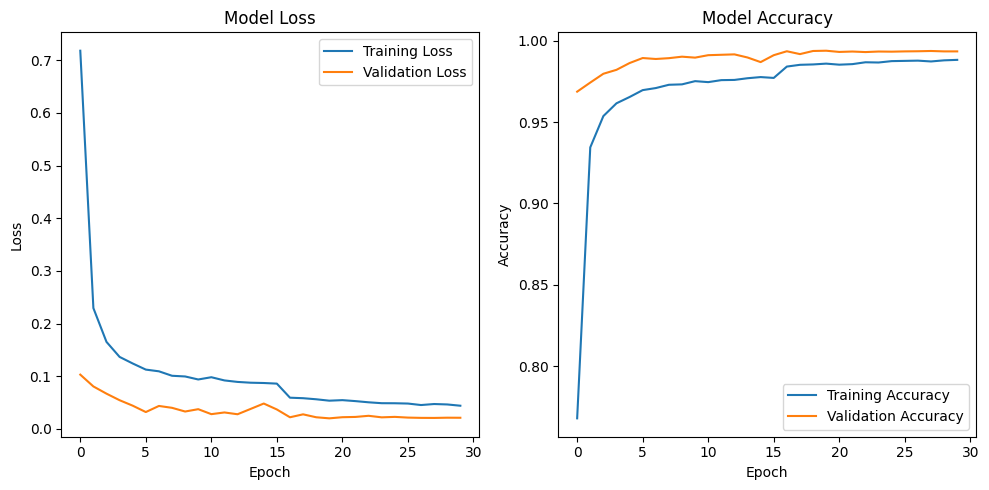

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate

# Funktionen zum Berechnen der zusätzlichen Merkmale
def calculate_total_intensity(image):
    return np.sum(image)

def calculate_symmetry(image):
    flipped_image = np.flip(image, axis=1)
    difference = np.sum(np.abs(image - flipped_image))
    return difference

def calculate_loops(image):
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    return num_labels - 1

# Funktion zum Erstellen des kombinierten Modells
def create_combined_model(cnn_model, num_extra_features):
    extra_features_input = Input(shape=(num_extra_features,))
    x = Dense(32, activation='relu')(extra_features_input)
    extra_features_model = Model(inputs=extra_features_input, outputs=x)

    combined_input = concatenate([cnn_model.output, extra_features_model.output])
    x = Dense(64, activation='relu')(combined_input)
    x = Dense(10, activation='softmax')(x)

    combined_model = Model(inputs=[cnn_model.input, extra_features_input], outputs=x)

    return combined_model

def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Erstellen Sie ein 1x2-Subplot-Raster

    # Modellverlust
    axs[0].plot(history.history['loss'], label='Training Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Model Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Modellgenauigkeit
    axs[1].plot(history.history['accuracy'], label='Training Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Model Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Daten laden
train_images, train_labels, test_images, test_labels = load_mnist_data()

# Daten vorverarbeiten
X_train, X_val, Y_train, Y_val, test_images, test_labels, input_shape = preprocess_data(train_images, train_labels, test_images, test_labels, test_size=TEST_SIZE, random_seed=SEED)

# Modell trainieren
model, history, callbacks, early_stopping_callback = train_model(X_train, Y_train, X_val, Y_val, input_shape, epochs=epochs, batch_size=batch_size, early_stopping_enabled=early_stopping_enabled)


# Trainingsverlauf plotten
plot_training_history(history)